In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}

import tensorflow as tf
from keras.datasets import mnist

import numpy as np

import matplotlib.pyplot as plt



from tensorflow import keras
from tensorflow.keras import layers

from keras.models import Model

from keras.layers import Conv2D, MaxPool2D, ZeroPadding2D, UpSampling2D, Input, Dense, Activation, Flatten, Reshape

from keras.utils import np_utils


from sklearn.model_selection import train_test_split

# Loading the data

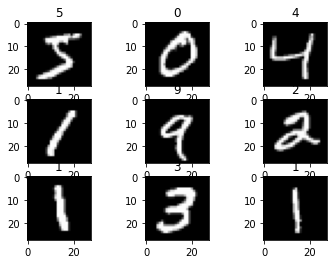

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Scale images to the [0, 1] range

X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255

X_train, X_test = X_train.reshape((-1,28,28,1)), X_test.reshape((-1,28,28,1))

for i in range(9):  
    plt.subplot(330 + 1 + i)
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
    plt.title(str(y_train[i]))
plt.show()

# Convolutive Autoencoder


In [4]:
def build_autoencoder(img_shape, embed_size):
    # The encoder

    inp = Input(shape=img_shape)

    conv1 = Conv2D(32, (3,3), activation='relu')(inp)

    conv2 = Conv2D(16, (3,3), activation='relu')(conv1)
    
    mp1   = MaxPool2D((2,2))(conv2)
    
    conv3 = Conv2D(8, (3,3), activation='relu')(mp1)
    
    flat = Flatten()(conv3)
    
    emb = Dense(embed_size, activation='sigmoid')(flat)
    
    encoder = Model(inputs=inp, outputs=emb)
    
    # The decoder
    
    decoder_input = Input(shape=(embed_size,))
    
    fc1 = Dense(800, activation='sigmoid')(decoder_input)

    res = Reshape((10,10,8))(fc1)

    zp1 = ZeroPadding2D((1,1))(res)

    conv4 = Conv2D(16, (3,3), padding='same', activation='relu')(zp1)

    up1 = UpSampling2D((2,2))(conv4)

    zp2 = ZeroPadding2D((1,1))(up1)

    conv5 = Conv2D(32, (3,3), padding='same', activation='relu')(zp2)

    zp3 = ZeroPadding2D((1,1))(conv5)

    conv6 = Conv2D(1, (3,3), padding='same', activation='relu')(zp3)

    decoder = Model(inputs=decoder_input, outputs=conv6)
    
    return encoder, decoder

In [5]:
img_shape=(28,28,1)

encoder, decoder = build_autoencoder(img_shape=img_shape, embed_size=32)

inp = Input(img_shape)
emb = encoder(inp)
reconstruction = decoder(emb)

autoencoder = Model(inp,reconstruction)
autoencoder.compile(optimizer='adamax', loss='mse')

print(autoencoder.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 model (Functional)          (None, 32)                31736     
                                                                 
 model_1 (Functional)        (None, 28, 28, 1)         32497     
                                                                 
Total params: 64,233
Trainable params: 64,233
Non-trainable params: 0
_________________________________________________________________
None


In [7]:
history = autoencoder.fit(x=X_train, y=X_train, epochs=5, batch_size=3,
                validation_data=[X_test, X_test])

Epoch 1/5
20000/20000 [==============================] - 195s 10ms/step - loss: 0.0166 - val_loss: 0.0098
Epoch 2/5
20000/20000 [==============================] - 197s 10ms/step - loss: 0.0089 - val_loss: 0.0077
Epoch 3/5
20000/20000 [==============================] - 199s 10ms/step - loss: 0.0075 - val_loss: 0.0069
Epoch 4/5
20000/20000 [==============================] - 200s 10ms/step - loss: 0.0064 - val_loss: 0.0059
Epoch 5/5
20000/20000 [==============================] - 201s 10ms/step - loss: 0.0058 - val_loss: 0.0058


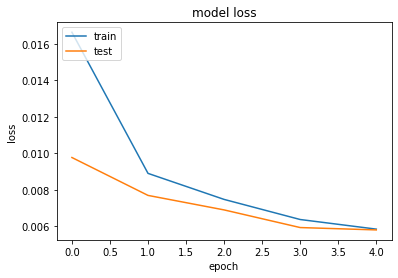

In [8]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

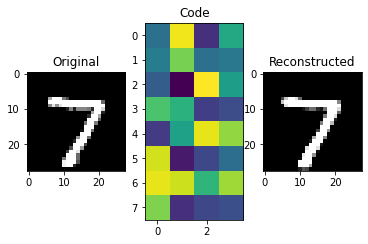

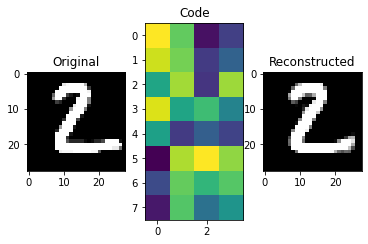

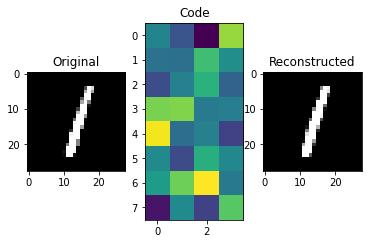

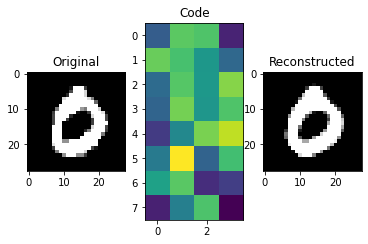

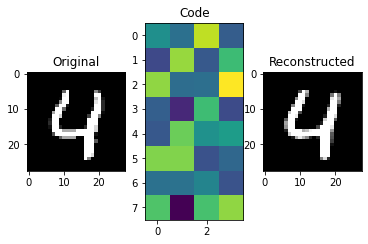

In [9]:
def show_image(x):
    plt.imshow(np.clip(x + 0.5, 0, 1), cmap=plt.get_cmap('gray'))
    
def visualize(img, encoder, decoder):
    """Draws original, encoded and decoded images"""
    # img[None] will have shape of (1, 32, 32, 3) which is the same as the model input
    code = encoder.predict(img[None])[0]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//4,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco)
    plt.show()

for i in range(5):
    img = X_test[i]
    visualize(img, encoder, decoder)

# CNN

In [10]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# Make sure images have shape (28, 28, 1)

print("X_train shape:", X_train.shape)
print(X_train.shape[0], "train samples")
print(X_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

X_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [11]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                                                 
 dropout (Dropout)           (None, 1600)              0

In [12]:
batch_size = 16
epochs = 5

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history_cnn = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/5
3375/3375 [==============================] - 29s 9ms/step - loss: 0.1923 - accuracy: 0.9405 - val_loss: 0.0570 - val_accuracy: 0.9842
Epoch 2/5
3375/3375 [==============================] - 29s 9ms/step - loss: 0.0784 - accuracy: 0.9759 - val_loss: 0.0427 - val_accuracy: 0.9890
Epoch 3/5
3375/3375 [==============================] - 29s 9ms/step - loss: 0.0614 - accuracy: 0.9810 - val_loss: 0.0362 - val_accuracy: 0.9900
Epoch 4/5
3375/3375 [==============================] - 29s 9ms/step - loss: 0.0530 - accuracy: 0.9833 - val_loss: 0.0334 - val_accuracy: 0.9900
Epoch 5/5
3375/3375 [==============================] - 29s 9ms/step - loss: 0.0478 - accuracy: 0.9851 - val_loss: 0.0307 - val_accuracy: 0.9912


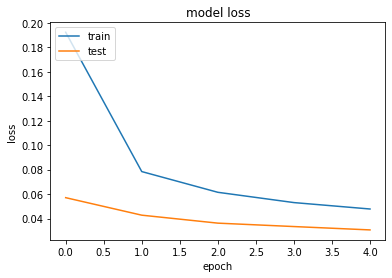

In [13]:
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Builiding the pipeline

In [22]:
def cae_pipline(image, noise_factor):
    
    # img[None] will have shape of (1, 32, 32, 3) which is the same as the model input
    embed = encoder.predict(image[None])[0]
    noisy_embed = embed + noise_factor*np.random.normal(loc=0.0, scale=1.0, size=embed.shape) 
    reco = decoder.predict(noisy_embed[None])[0]
    return reco, embed, noisy_embed

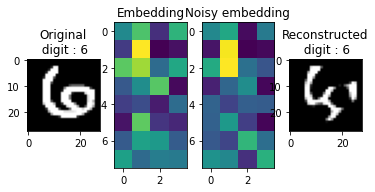

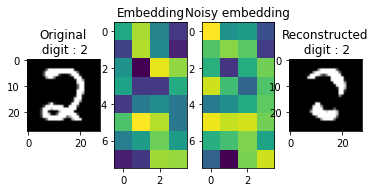

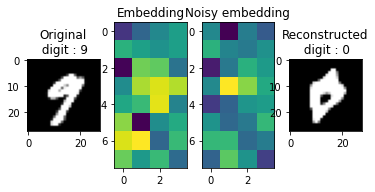

In [98]:
for i in [54, 72, 20]:
    img = X_test[i]
    #Get the reconstructed image, the embedding and the embedding + Gaussian noise 
    reco, embed, noisy_embed = cae_pipline(image=img, noise_factor=0.15)

    #predict on original test image and reconstructed one using the CNN:
    pred_or = model.predict(img[None])[0]
    pred_to_digit_or = np.argmax(pred_or)
    
    pred_rec = model.predict(reco[None])[0]
    pred_to_digit_rec = np.argmax(pred_rec)
    #Plot different images and embeddings:
    plt.subplot(1,4,1)
    plt.title("Original\n digit : "+str(pred_to_digit_or))
    show_image(img)
    
    plt.subplot(1,4,2)
    plt.title("Embedding")
    plt.imshow(embed.reshape([embed.shape[-1]//4,-1]))
    
    plt.subplot(1,4,3)
    plt.title("Noisy embedding")
    plt.imshow(noisy_embed.reshape([embed.shape[-1]//4,-1]))

    plt.subplot(1,4,4)
    plt.title("Reconstructed\n digit : "+str(pred_to_digit_rec))
    show_image(reco)
    plt.show()

# Measuring the variation between original and reconstructed images

In [221]:
n = 500
p = 10 #number of perturbations
mse = np.zeros((n,p))
MSE_per_image = np.zeros((n,2))
MSE_per_image_t = np.zeros(10)

for i in range(n):
    
    img = X_test[i]
    #test 10 different perturbations :
    for j,nf in enumerate(np.linspace(0.05,0.15,p)):
        reco, _, _ = cae_pipline(image=img, noise_factor=nf)
        #MSE between img and reco for each perturbation :
        mse[i,j] = np.mean((img-reco)**2)
    MSE_per_image_t[np.argmax(y_train[i])] = np.maximum(np.mean(mse[i,:]), MSE_per_image_t[np.argmax(y_train[i])])

array([0.04988408, 0.05038747, 0.06068266, 0.0488609 , 0.06402214,
       0.05077684, 0.05385498, 0.04728078, 0.04391006, 0.05115694])

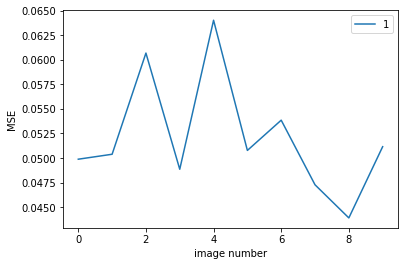

In [222]:
plt.plot(MSE_per_image_t)
plt.legend(range(1,11), loc='upper right')
plt.xlabel('image number')
plt.ylabel('MSE')
MSE_per_image_t

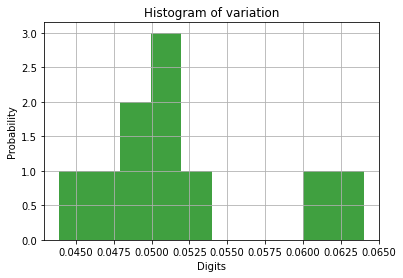

In [227]:
plt.hist(MSE_per_image_t, 10, density=False, facecolor='g', alpha=0.75)


plt.xlabel('Digits')
plt.ylabel('Probability')
plt.title('Histogram of variation')
plt.grid(True)
plt.show()

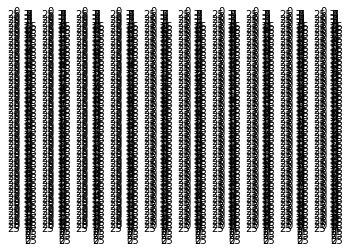

In [225]:
image_variation_ind = (-MSE_per_image[:,1]).argsort()
for i in range(len(image_variation_ind)):
    im = image_variation_ind[i]
    plt.subplot(50,10,i+1)
    plt.imshow(X_test[im], cmap=plt.get_cmap('gray'))
plt.show()